In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from optbinning import OptimalBinning, BinningProcess, Scorecard
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from optbinning.scorecard import plot_auc_roc, plot_ks

## Data Preprocessing 

In [97]:
df_accepted = pd.read_csv('accepted_customers.csv')
print(df_accepted.shape)
df_rejected = pd.read_csv('rejected_customers.csv')
print(df_rejected.shape)

(3000, 24)
(1500, 22)


df_accepted has the additional two columns:
- GB: Good – 0 / Bad – 1 
- _freq_: Weight variable

To comply with FDIC regulations 'NAT', 'AGE', 'EC_CARD', 'PERS_H', 'CHILDREN' can not be used in the model.

In [98]:
df_accepted = df_accepted.drop(columns=['NAT', 'AGE', 'EC_CARD', 'PERS_H', 'CHILDREN'])
df_rejected = df_rejected.drop(columns=['NAT', 'AGE', 'EC_CARD', 'PERS_H', 'CHILDREN'])

train, test = train_test_split(df_accepted, test_size = 0.3, random_state = 88)

# X's data types 
Nominal = ['BUREAU', 'CAR', 'CARDS', 'NAT', 'PRODUCT', 'PROF', 'REGN', 'TEL']
Binary = ['DIV', 'EC_CARD', 'FINLOAN', 'LOCATION', 'RESID', '_freq_']

# define Y
y = train['GB']

## Model Building: OptBinning + Scorecard

In credit modeling, IV is used in some instances to actually select which variables belong in the model. Here are some typical IV ranges for determining the strength of a predictor variable at predicting the target variable:

- 0 <= IV < 0.02 - Not Predictor
- 0.02 <= IV < 0.1 - Weak Predictor
- 0.1 <= IV < 0.25 - Moderate Predictor
- 0.25 <= IV < 1 - Strong Predictor

In [99]:
colnames = list(train.drop(columns=['GB', '_freq_']))
X = train[colnames]

# select variables with IV values above 0.1
selection_criteria = {'iv': {'min': 0.1, 'max': 1}}

bin_proc = BinningProcess(colnames, selection_criteria = selection_criteria, categorical_variables = Nominal+Binary)

iv_all = bin_proc.fit(X, y).summary()

iv_all[iv_all.columns[0:6]].sort_values(by = ['iv'], ascending = False)

,name,dtype,status,selected,n_bins,iv
1,TMJOB1,numerical,OPTIMAL,True,8,0.246733
5,INCOME,numerical,OPTIMAL,True,7,0.232868
16,CARDS,categorical,OPTIMAL,True,2,0.184892
2,TEL,categorical,OPTIMAL,False,2,0.085212
0,TMADD,numerical,OPTIMAL,False,6,0.055525
15,CAR,categorical,OPTIMAL,False,2,0.052674
14,PROF,categorical,OPTIMAL,False,3,0.04996
3,NMBLOAN,numerical,OPTIMAL,False,2,0.043912
9,REGN,categorical,OPTIMAL,False,8,0.038
11,CASH,numerical,OPTIMAL,False,5,0.025654


We see that only three carriables meet our IV selction critera. We can even transform those varriables into their optimal bins. 

In [100]:
data_transformed = bin_proc.transform(train[['TMJOB1', 'INCOME', 'CARDS']])
data_transformed

,TMJOB1,INCOME,CARDS
2576,-0.526646,-0.545621,-0.265552
1961,0.004762,-0.162047,-0.265552
1659,0.309278,0.179013,-0.265552
2679,-0.526646,-1.008105,-0.265552
1722,0.309278,0.696928,0.707080
...,...,...,...
2964,-0.767625,-0.162047,-0.265552
362,0.309278,0.068319,-0.265552
2481,-0.197012,-0.545621,-0.265552
2336,-0.197012,-0.545621,-0.265552


In [101]:
estimator = LogisticRegression(solver = "lbfgs")

# create the scorecard
scorecard = Scorecard(binning_process = bin_proc,
                      estimator = estimator, scaling_method = "pdo_odds",
                      scaling_method_params = {"pdo": 50, 
                      "scorecard_points": 1500, "odds": 1500})
                      
scorecard.fit(X, y, sample_weight = train["_freq_"])

Scorecard(binning_process=BinningProcess(categorical_variables=['BUREAU', 'CAR',
                                                                'CARDS', 'NAT',
                                                                'PRODUCT',
                                                                'PROF', 'REGN',
                                                                'TEL', 'DIV',
                                                                'EC_CARD',
                                                                'FINLOAN',
                                                                'LOCATION',
                                                                'RESID',
                                                                '_freq_'],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.1}},
                                         variable_names=['TMADD', 'TMJOB1',
                                                         'TEL', 'NMBLOAN',
                                                         'FINLOAN', 'INCOME',
                                                         'BUREAU', 'LOCATION',
                                                         'LOANS', 'REGN', 'DIV',
                                                         'CASH', 'PRODUCT',
                                                         'RESID', 'PROF', 'CAR',
                                                         'CARDS']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 1500, 'pdo': 50,
                                 'scorecard_points': 1500})

If we want to see the actual coefficients from the logistic regression for each of the variables we can do the following.

In [102]:
scorecard.table(style = "detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,TMJOB1,0,"(-inf, 7.50)",1642,0.050899,1530,112,0.068210,-0.767625,0.043464,5.303468e-03,-0.932843,353.823619
1,TMJOB1,1,"[7.50, 16.50)",3934,0.121947,3720,214,0.054398,-0.526646,0.043530,5.379287e-03,-0.932843,370.039185
2,TMJOB1,2,"[16.50, 31.50)",5311,0.164631,5100,211,0.039729,-0.197012,0.007013,8.751648e-04,-0.932843,392.220449
3,TMJOB1,3,"[31.50, 69.00)",8622,0.267266,8340,282,0.032707,0.004762,0.000006,7.559786e-07,-0.932843,405.797891
4,TMJOB1,4,"[69.00, 90.00)",1797,0.055704,1740,57,0.031720,0.036440,0.000073,9.089648e-06,-0.932843,407.929497
5,TMJOB1,5,"[90.00, 156.00)",4028,0.124861,3930,98,0.024330,0.309278,0.010364,1.290300e-03,-0.932843,426.288891
6,TMJOB1,6,"[156.00, 264.00)",3987,0.123590,3930,57,0.014296,0.851194,0.061446,7.456961e-03,-0.932843,462.754666
7,TMJOB1,7,"[264.00, inf)",2939,0.091104,2910,29,0.009867,1.226463,0.080837,9.515427e-03,-0.932843,488.006684
8,TMJOB1,8,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-0.932843,405.477438
9,TMJOB1,9,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-0.932843,405.477438


Credit models are evaluated as most classification models. Overall model performance is typically evaluated on area under the ROC curve as well as the K-S statistic

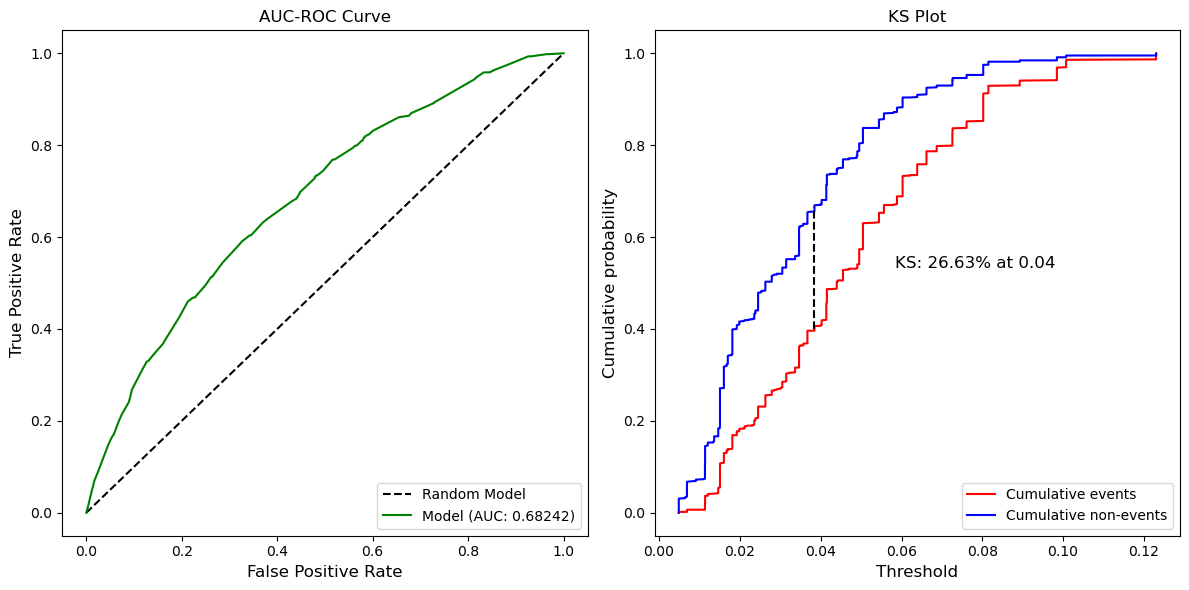

In [103]:
y_pred = scorecard.predict_proba(X)[:, 1] # Generate predictions

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0]) 
plot_auc_roc(y, y_pred)
axes[0].set_title("AUC-ROC Curve")
plt.sca(axes[1])
plot_ks(y, y_pred)
axes[1].set_title("KS Plot")
plt.tight_layout()
plt.show()


## Reject Inference
The credit scoring model above is based only on the applicants who got loans (accepted applicants) is called a behavioral scorecard because it models the behavior of your current loans. Regulatory compliance (FDIC) requires the usage of reject inference, thus we will preform reject inference using rejected customers data. Steps are as follows:   
        1) - Create reject inference dataset.     
        2) - Same process as before where we split into training and testing, re-bin all of the variables, and rebuild the logistic regression model

In [104]:
### Build the reject inference data

rejects = df_rejected
accepts = df_accepted

rejects["y_pred"] = scorecard.predict_proba(rejects)[:, 1]

rejects["GB"] = (rejects["y_pred"] > 0.04).astype(int) # 0.04 from KS stat
# rejects["_cost_"] = rejects["GB"].apply(lambda x: 2000 if x == 0 else -52000) # profit & cost defined in RFP
rejects["_freq_"] = rejects["GB"].apply(lambda x: 30 if x == 0 else 1) # maintain current event rate

rejects = rejects.drop("y_pred", axis=1)

comb_hard = pd.concat([accepts, rejects.head(1000)], ignore_index=True) # only 100 to keep the existing acceptance rate at 75%

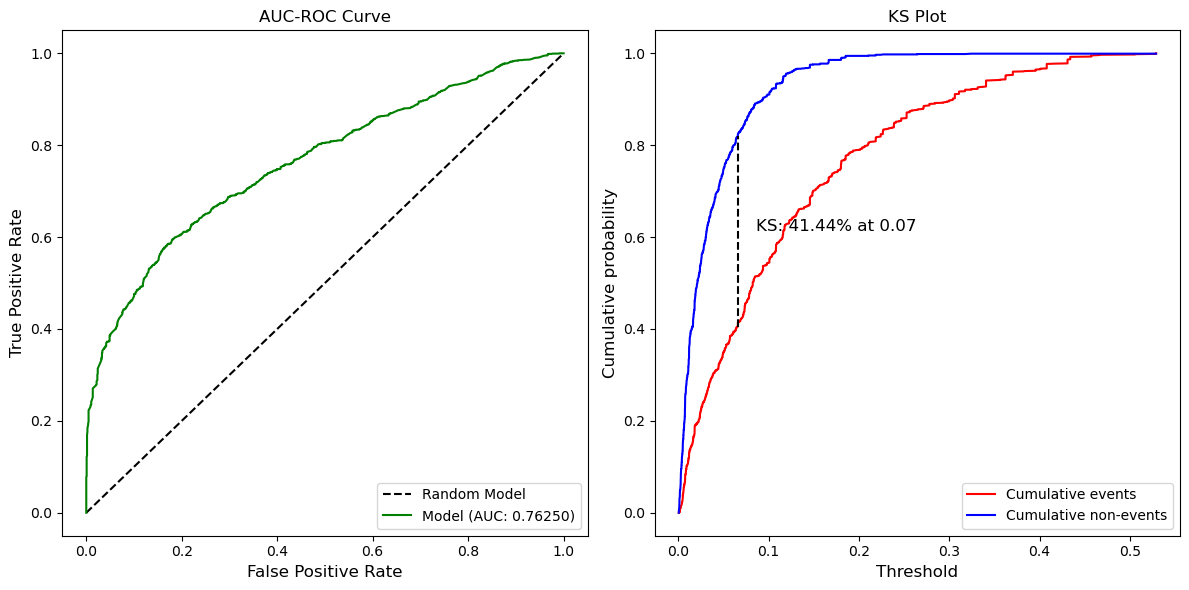

In [109]:
### Same steps as before

train, test = train_test_split(comb_hard, test_size = 0.3, random_state = 88)
y = train['GB']

colnames = list(train.drop(columns=['GB', '_freq_']))
X = train[colnames]

# create the scorecard
scorecard = Scorecard(binning_process = bin_proc,
                      estimator = estimator, scaling_method = "pdo_odds",
                      scaling_method_params = {"pdo": 50, 
                      "scorecard_points": 1500, "odds": 1500})
                      
scorecard.fit(X, y, sample_weight = train["_freq_"])

y_pred = scorecard.predict_proba(X)[:, 1] # Generate predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.sca(axes[0]) 
plot_auc_roc(y, y_pred)
axes[0].set_title("AUC-ROC Curve")
plt.sca(axes[1])
plot_ks(y, y_pred)
axes[1].set_title("KS Plot")
plt.tight_layout()
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

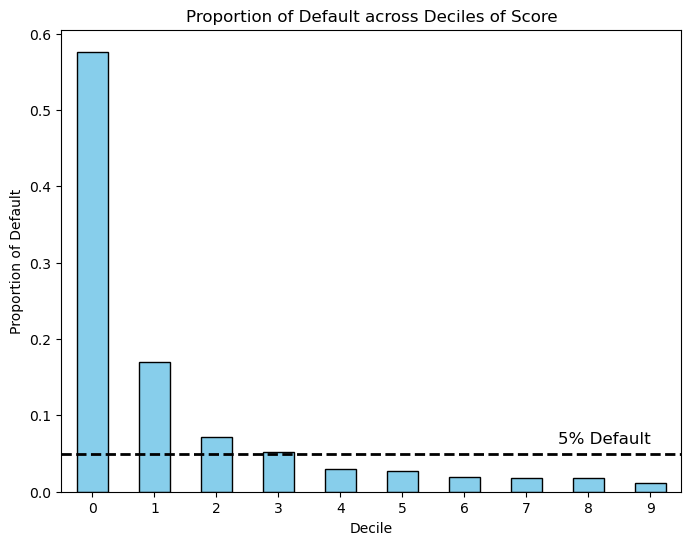

In [118]:
test_final = comb_hard
test_final["score"] = scorecard.score(test_final)
test_final['decile'] = pd.qcut(test_final["score"], 10, labels = False)
PD = test_final[test_final['GB'] == 1].groupby('decile').size() / (test_final[test_final['GB'] == 0].groupby('decile').size() * 30 + test_final[test_final['GB'] == 1].groupby('decile').size())


plt.figure(figsize = (8, 6))
PD.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.axhline(y = 0.05, color = 'black', linestyle = '--', linewidth = 2)
plt.text(x = 9, y = 0.06, s = '5% Default', color = 'black', ha = 'right', va = 'bottom', fontsize = 12)

plt.title('Proportion of Default across Deciles of Score')
plt.xlabel('Decile')
plt.ylabel('Proportion of Default')
plt.xticks(rotation = 0)